# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

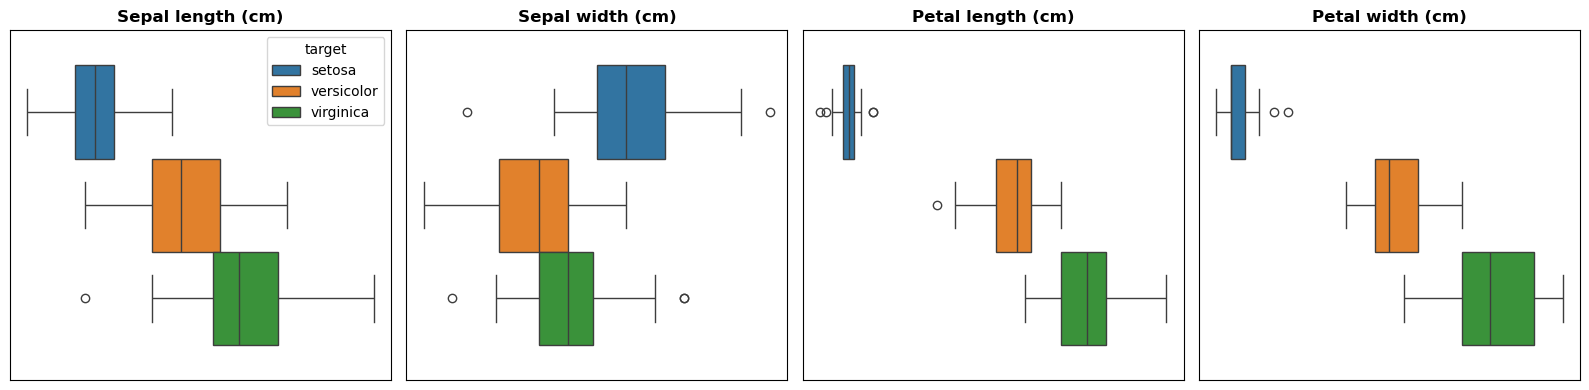

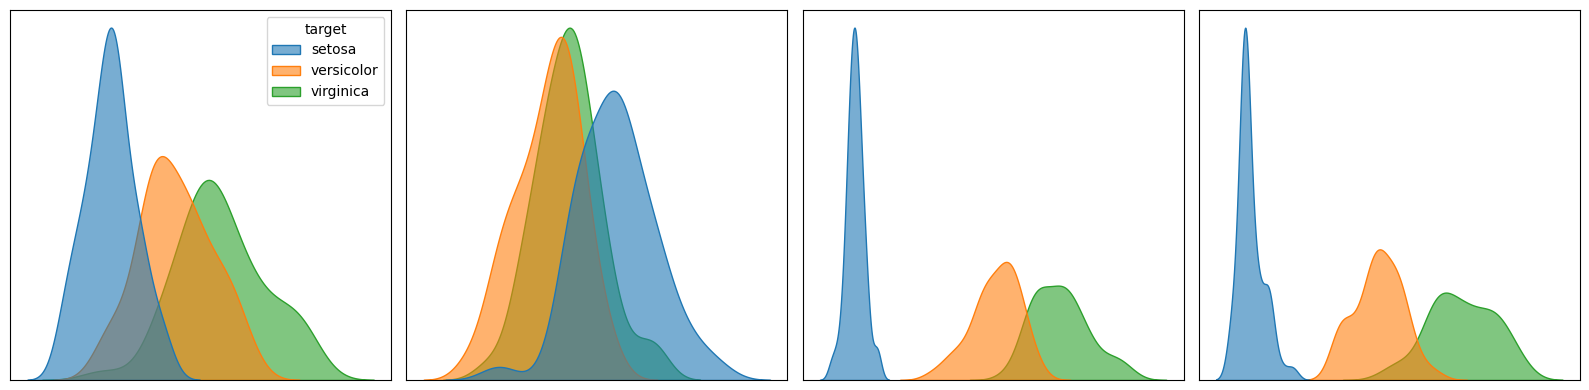

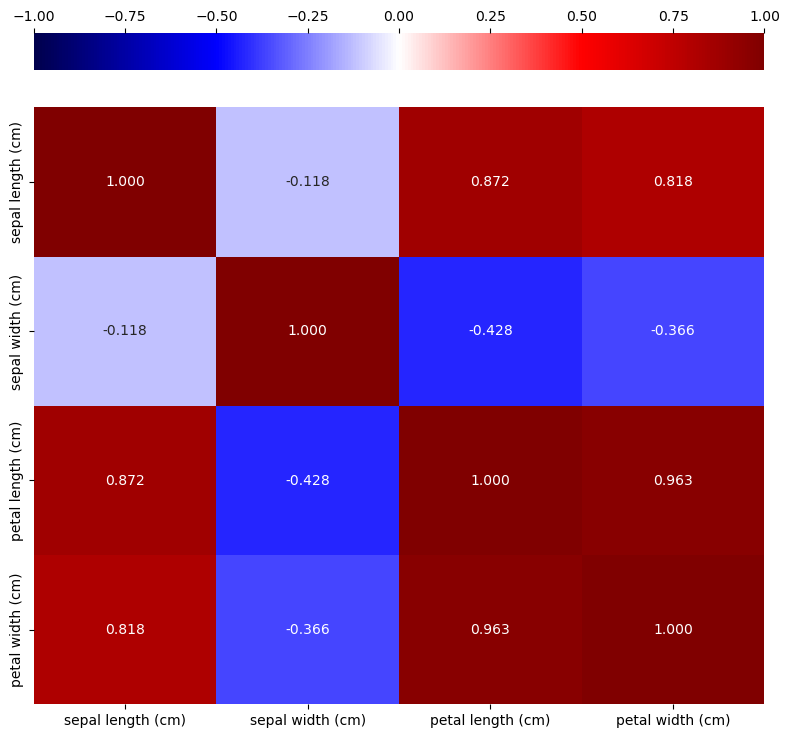

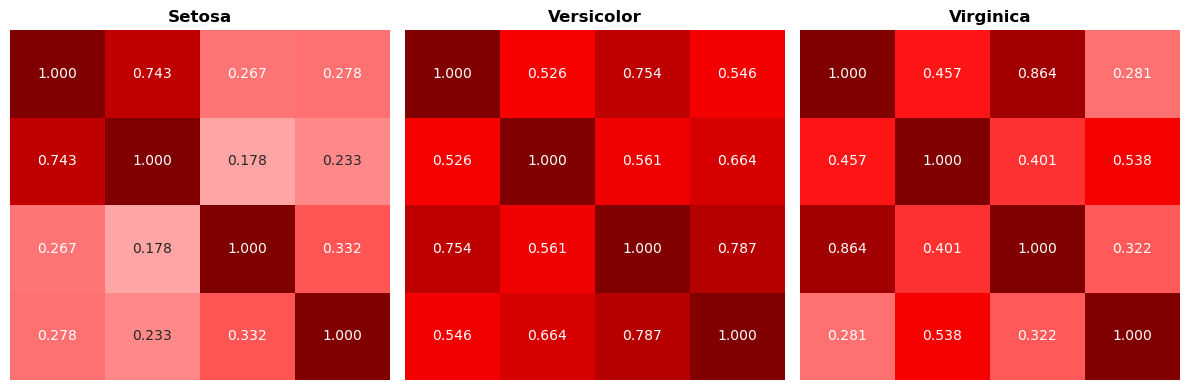

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.697803,3.683087,0.615771,1.649557,setosa
1,6.075788,3.409811,0.268556,-0.601148,setosa
2,5.503487,3.191399,1.189481,-0.606129,setosa
3,4.409636,2.252597,0.168222,-1.035723,setosa
4,4.576860,4.541348,1.044193,1.826618,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.069      5.889   
     sepal width (cm)   3.428      2.770     2.974     3.590      2.491   
     petal length (cm)  1.462      4.260     5.552     1.386      4.189   
     petal width (cm)   0.246      1.326     2.026     0.058      1.445   
STD  sepal length (cm)  0.352      0.516     0.636     1.110      0.984   
     sepal width (cm)   0.379      0.314     0.322     1.031      1.078   
     petal length (cm)  0.174      0.470     0.552     0.941      1.213   
     petal width (cm)   0.105      0.198     0.275     1.171      0.982   
MIN  sepal length (cm)  4.300      4.900     4.900     2.190      3.162   
     sepal width (cm)   2.300      2.000     2.200     1.318      0.104   
     petal length (cm)  1.000      3.000     4.500    -0.289      1.074   
     petal width (cm)   0.100      1.000     1.400    -3.426     -0.429   
MAX  sepal length (cm)  5.800      7.000     7.900     7.237      8.040   
     sepal width (cm)   4.400      3.400     3.800     6.051      4.520   
     petal length (cm)  1.900      5.100     6.900     4.158      6.159   
     petal width (cm)   0.600      1.800     2.500     1.827      4.015   
SKEW sepal length (cm)  0.116      0.102     0.114    -0.243     -0.481   
     sepal width (cm)   0.040     -0.352     0.355     0.003     -0.061   
     petal length (cm)  0.103     -0.588     0.533     0.618     -0.426   
     petal width (cm)   1.216     -0.030    -0.126    -0.495      0.471   
KURT sepal length (cm) -0.346     -0.599    -0.088     0.310      0.406   
     sepal width (cm)   0.744     -0.448     0.520    -0.197     -0.496   
     petal length (cm)  0.805     -0.074    -0.256     0.615     -0.179   
     petal width (cm)   1.434     -0.488    -0.661     0.316      0.440   
IQR  sepal length (cm)  0.400      0.700     0.675     1.219      1.137   
     sepal width (cm)   0.475      0.475     0.375     1.466      1.487   
     petal length (cm)  0.175      0.600     0.775     1.227      1.677   
     petal width (cm)   0.100      0.300     0.500     1.623      1.054   

                                  
                       virginica  
MEAN sepal length (cm)     6.487  
     sepal width (cm)      2.924  
     petal length (cm)     5.608  
     petal width (cm)      2.237  
STD  sepal length (cm)     1.310  
     sepal width (cm)      1.019  
     petal length (cm)     1.208  
     petal width (cm)      1.116  
MIN  sepal length (cm)     3.531  
     sepal width (cm)      0.587  
     petal length (cm)     2.628  
     petal width (cm)     -0.528  
MAX  sepal length (cm)     9.323  
     sepal width (cm)      5.095  
     petal length (cm)     7.871  
     petal width (cm)      4.380  
SKEW sepal length (cm)     0.021  
     sepal width (cm)     -0.388  
     petal length (cm)    -0.364  
     petal width (cm)     -0.058  
KURT sepal length (cm)    -0.277  
     sepal width (cm)     -0.151  
     petal length (cm)     0.001  
     petal width (cm)     -0.641  
IQR  sepal length (cm)     1.645  
     sepal width (cm)      1.196  
     petal length (cm)     1.412  
     petal width (cm)      1.767

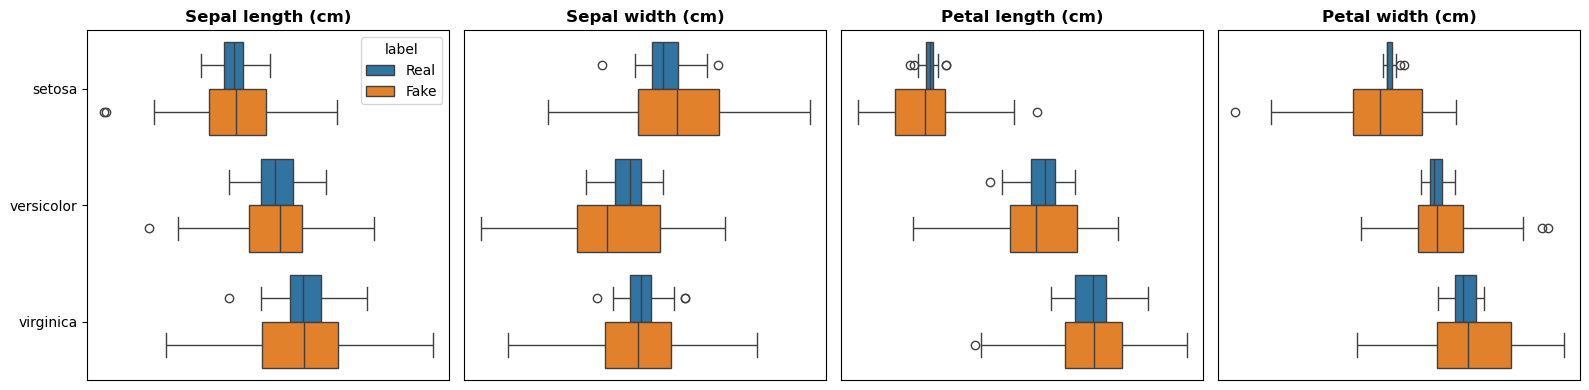

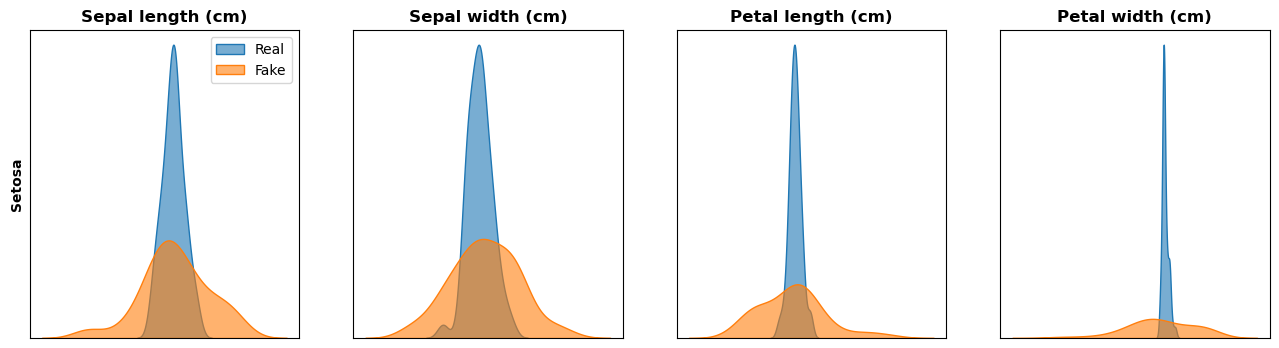

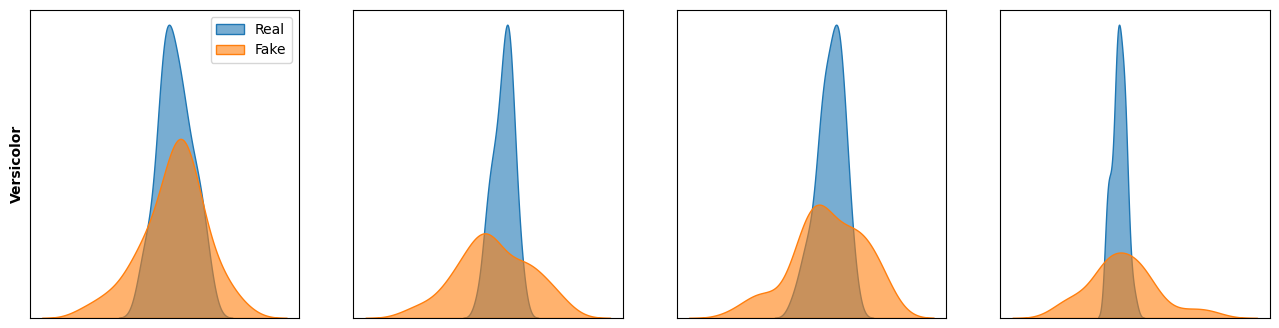

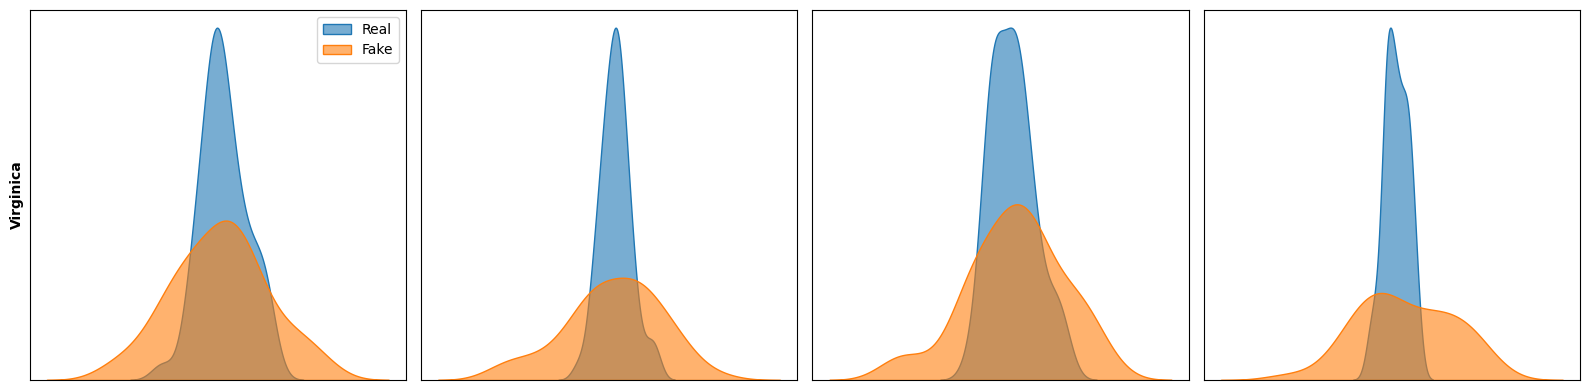

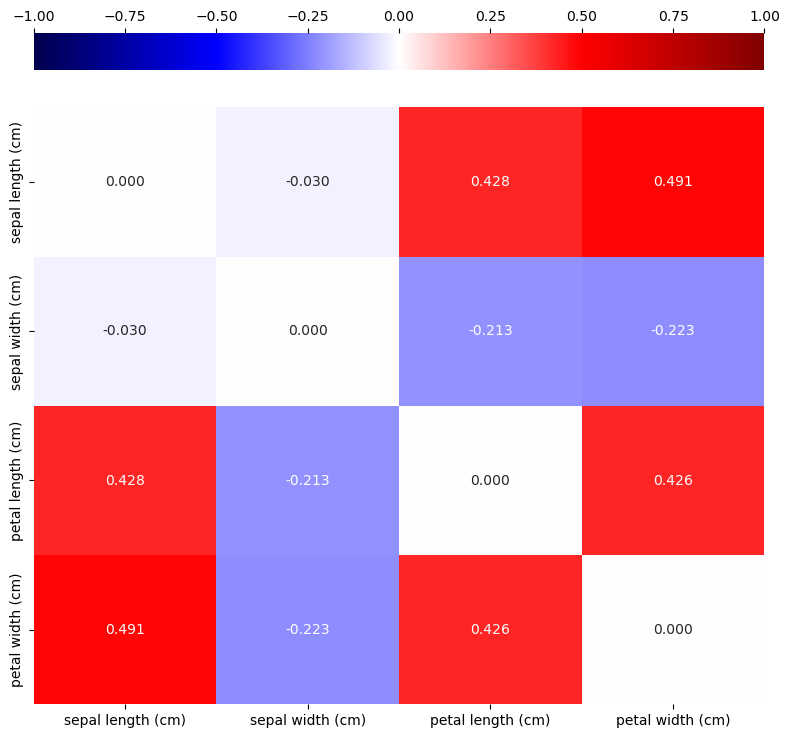

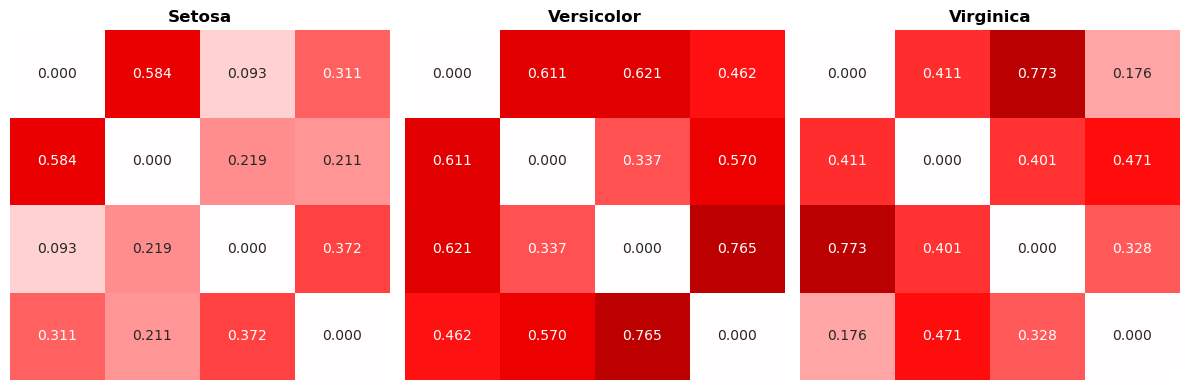

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    

vae = ConditionalVAE(input_dim = 4, latent_dim = 4, condition_dim = 3)

for batch in real_vae_dataloader:
    vae_batch = batch
    break
    
vae_out = vae(vae_batch[0], vae_batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])


Now let's build the GANs net.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

gen = Generator(input_dim = 4, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    gan_batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 4), gan_batch[1]).shape}')
print(f'Discriminator output shape: {disc(gan_batch[0], gan_batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [14]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')
print(f'Disc has {sum(p.numel() for p in disc.parameters())} parameters')

VAE has 1724 parameters
Gen has 861 parameters
Disc has 714 parameters


We can now train the simpliest Conditional VAE.

In [15]:
vae_opt = torch.optim.Adam(vae.parameters(), lr = 1e-3)

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)

    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

set_seed()

z = torch.randn(150, 4)

In [16]:
for epoch in tqdm(range(1, 501), desc = 'Training VAE'):
    
    vae.train()
    epoch_loss = 0
    
    for data, label in real_vae_dataloader:
        
        reconstructed, mu, logvar = vae(data, label)
        loss, recon_loss, kl_div = vae_loss(reconstructed, data, mu, logvar)
        
        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()
        
        epoch_loss += loss.item()
        
    epoch_total_loss = epoch_loss/len(real_vae_dataloader)
    
    if epoch % 10 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/50 | Loss: {epoch_total_loss:.4f}')
        with torch.no_grad():
            vae.eval()
            vae_z = vae(z, real_vae_dataloader.dataset.label)[0]
            utils.compare_results(real_vae_dataloader.dataset.data, vae_z)

Training VAE:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 10/50 | Loss: 0.8529
MEAN: [ 0.029 -0.032  0.021  0.047]
STD:  [0.837 0.917 0.816 0.865]
MIN:  [-1.41  -2.282 -1.076 -0.991]
MAX:  [2.173 2.885 1.54  1.55 ]
SKEW: [0.818 0.23  0.285 0.348]
KURT: [-0.273  1.054 -0.696 -1.011]

Epoch 20/50 | Loss: 0.4952
MEAN: [-0.004 -0.007 -0.044 -0.013]
STD:  [0.546 0.695 0.504 0.529]
MIN:  [-1.034 -2.032 -0.73  -0.61 ]
MAX:  [1.854 2.482 1.131 1.093]
SKEW: [ 0.692 -0.196  0.187  0.225]
KURT: [ 0.73   1.425 -0.031  0.03 ]

Epoch 30/50 | Loss: 0.3641
MEAN: [-0.012  0.016 -0.074 -0.044]
STD:  [0.352 0.499 0.304 0.31 ]
MIN:  [-0.895 -1.853 -0.592 -0.471]
MAX:  [1.688 2.269 0.933 0.846]
SKEW: [ 0.725 -0.279  0.216  0.29 ]
KURT: [0.914 1.589 0.097 0.169]

Epoch 40/50 | Loss: 0.3341
MEAN: [-0.009  0.005 -0.085 -0.051]
STD:  [0.299 0.474 0.24  0.249]
MIN:  [-0.89  -1.884 -0.585 -0.462]
MAX:  [1.643 2.278 0.865 0.785]
SKEW: [ 0.706 -0.352  0.193  0.257]
KURT: [0.93  1.634 0.113 0.173]

Epoch 50/50 | Loss: 0.3045
MEAN: [-0.007 -0.004 -0.077 -0.043]
STD:


Epoch 400/50 | Loss: 0.2928
MEAN: [-0.008 -0.    -0.089 -0.051]
STD:  [0.221 0.367 0.178 0.183]
MIN:  [-0.874 -1.621 -0.568 -0.448]
MAX:  [1.552 2.194 0.789 0.714]
SKEW: [ 0.51  -0.109  0.057  0.089]
KURT: [0.927 1.673 0.107 0.166]

Epoch 410/50 | Loss: 0.2929
MEAN: [-0.009 -0.003 -0.091 -0.054]
STD:  [0.219 0.367 0.177 0.182]
MIN:  [-0.873 -1.689 -0.568 -0.448]
MAX:  [1.553 2.196 0.789 0.714]
SKEW: [ 0.5   -0.113  0.061  0.099]
KURT: [0.926 1.677 0.106 0.167]

Epoch 420/50 | Loss: 0.2885
MEAN: [-0.002  0.011 -0.089 -0.051]
STD:  [0.22  0.361 0.177 0.182]
MIN:  [-0.873 -1.665 -0.568 -0.447]
MAX:  [1.553 2.197 0.789 0.714]
SKEW: [ 0.477 -0.134  0.055  0.088]
KURT: [0.928 1.676 0.107 0.167]

Epoch 430/50 | Loss: 0.2925
MEAN: [-0.019 -0.012 -0.105 -0.068]
STD:  [0.218 0.369 0.173 0.18 ]
MIN:  [-0.873 -1.68  -0.568 -0.447]
MAX:  [1.551 2.201 0.789 0.714]
SKEW: [ 0.541 -0.097  0.103  0.146]
KURT: [0.927 1.678 0.105 0.165]

Epoch 440/50 | Loss: 0.2928
MEAN: [-0.014  0.011 -0.098 -0.057]
STD

In [17]:
vae_df = pd.DataFrame(std_scl.inverse_transform(vae_z.detach().numpy()))
vae_df['target'] = y
vae_df['target'] = vae_df['target'].map({i: species[i] for i in range(len(species))})
vae_df.columns = real_iris.columns

In [18]:
utils.describe_data(real_iris, 'target', vae_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.022      5.929   
     sepal width (cm)   3.428      2.770     2.974     3.427      2.773   
     petal length (cm)  1.462      4.260     5.552     2.000      4.240   
     petal width (cm)   0.246      1.326     2.026     0.440      1.314   
STD  sepal length (cm)  0.352      0.516     0.636     0.001      0.030   
     sepal width (cm)   0.379      0.314     0.322     0.014      0.011   
     petal length (cm)  0.174      0.470     0.552     0.000      0.076   
     petal width (cm)   0.105      0.198     0.275     0.000      0.039   
MIN  sepal length (cm)  4.300      4.900     4.900     5.020      5.846   
     sepal width (cm)   2.300      2.000     2.200     3.365      2.732   
     petal length (cm)  1.000      3.000     4.500     1.999      4.048   
     petal width (cm)   0.100      1.000     1.400     0.440      1.226   
MAX  sepal length (cm)  5.800      7.000     7.900     5.027      5.975   
     sepal width (cm)   4.400      3.400     3.800     3.441      2.788   
     petal length (cm)  1.900      5.100     6.900     2.001      4.400   
     petal width (cm)   0.600      1.800     2.500     0.441      1.411   
SKEW sepal length (cm)  0.116      0.102     0.114     1.155     -1.134   
     sepal width (cm)   0.040     -0.352     0.355    -2.300     -1.285   
     petal length (cm)  0.103     -0.588     0.533     1.305     -0.420   
     petal width (cm)   1.216     -0.030    -0.126     1.460     -0.191   
KURT sepal length (cm) -0.346     -0.599    -0.088     2.164      0.957   
     sepal width (cm)   0.744     -0.448     0.520     6.491      2.380   
     petal length (cm)  0.805     -0.074    -0.256     2.328      0.059   
     petal width (cm)   1.434     -0.488    -0.661     3.447      0.357   
IQR  sepal length (cm)  0.400      0.700     0.675     0.002      0.029   
     sepal width (cm)   0.475      0.475     0.375     0.012      0.013   
     petal length (cm)  0.175      0.600     0.775     0.001      0.093   
     petal width (cm)   0.100      0.300     0.500     0.000      0.046   

                                  
                       virginica  
MEAN sepal length (cm)     6.590  
     sepal width (cm)      2.972  
     petal length (cm)     5.503  
     petal width (cm)      1.956  
STD  sepal length (cm)     0.016  
     sepal width (cm)      0.015  
     petal length (cm)     0.007  
     petal width (cm)      0.001  
MIN  sepal length (cm)     6.544  
     sepal width (cm)      2.916  
     petal length (cm)     5.481  
     petal width (cm)      1.951  
MAX  sepal length (cm)     6.612  
     sepal width (cm)      3.018  
     petal length (cm)     5.511  
     petal width (cm)      1.958  
SKEW sepal length (cm)    -1.154  
     sepal width (cm)     -0.925  
     petal length (cm)    -1.561  
     petal width (cm)     -1.572  
KURT sepal length (cm)     0.927  
     sepal width (cm)      4.168  
     petal length (cm)     2.222  
     petal width (cm)      2.475  
IQR  sepal length (cm)     0.019  
     sepal width (cm)      0.013  
     petal length (cm)     0.006  
     petal width (cm)      0.001

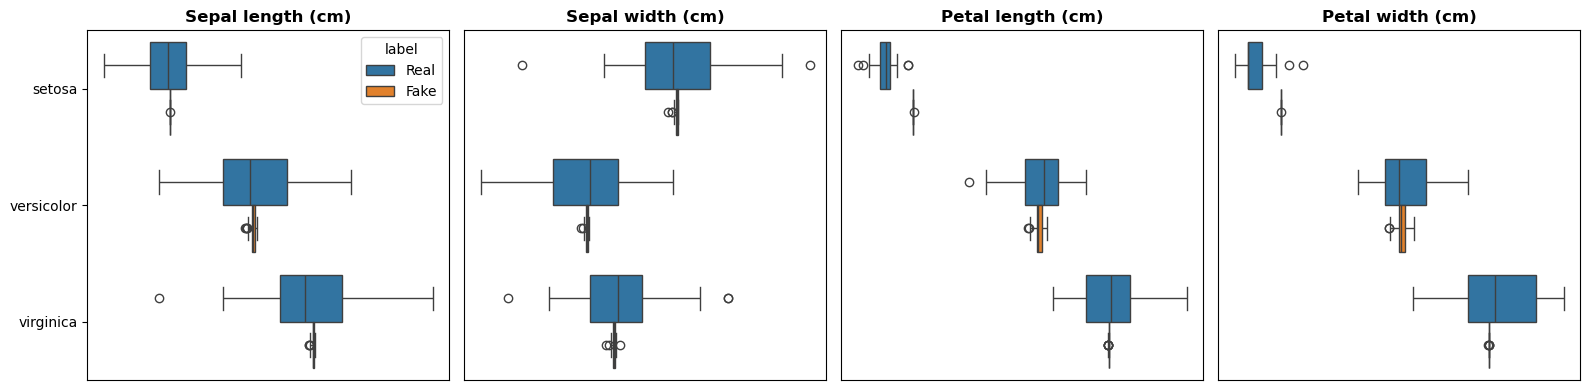

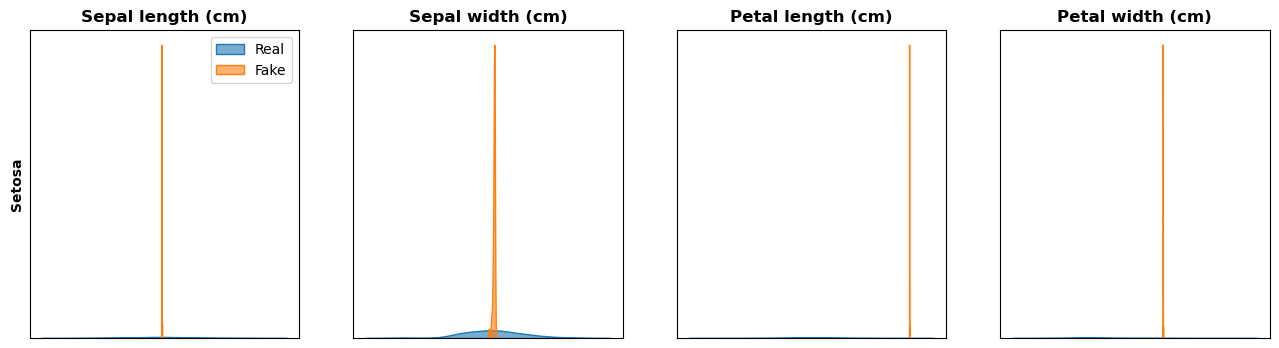

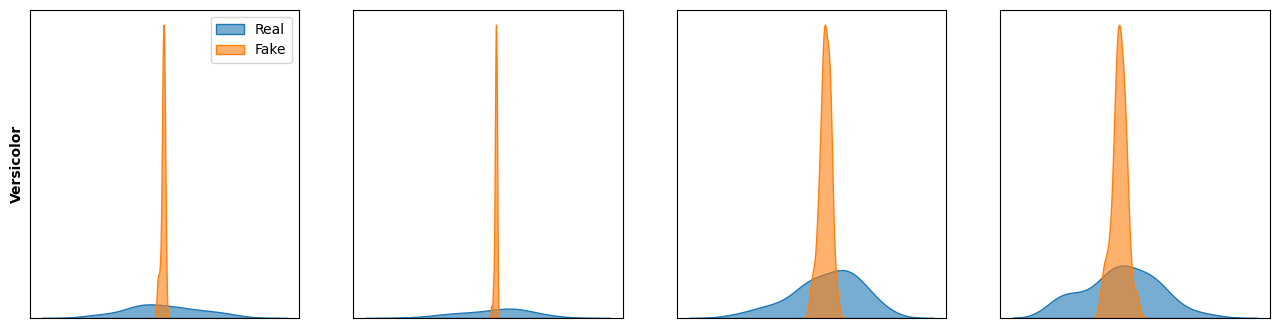

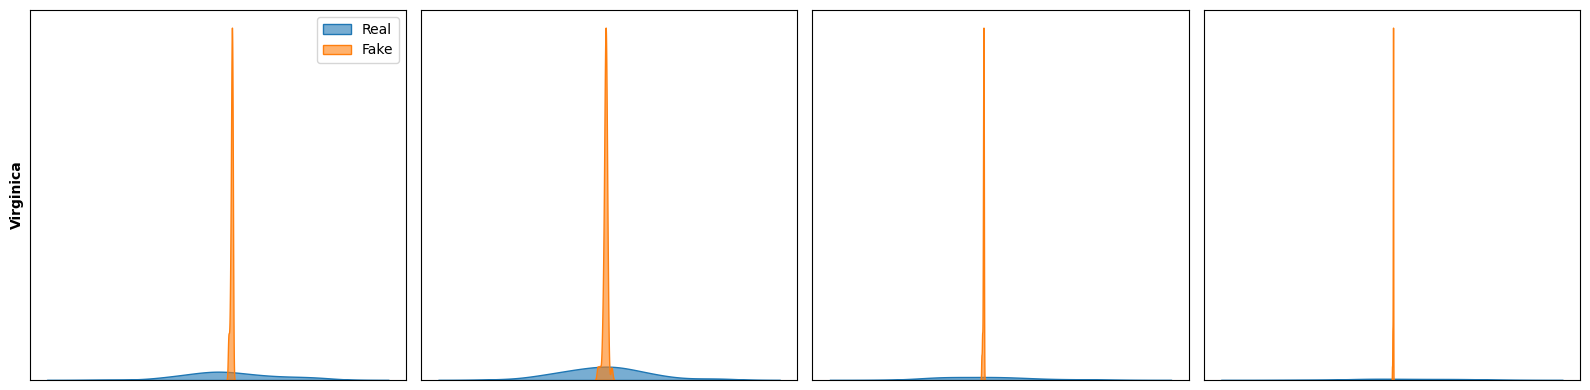

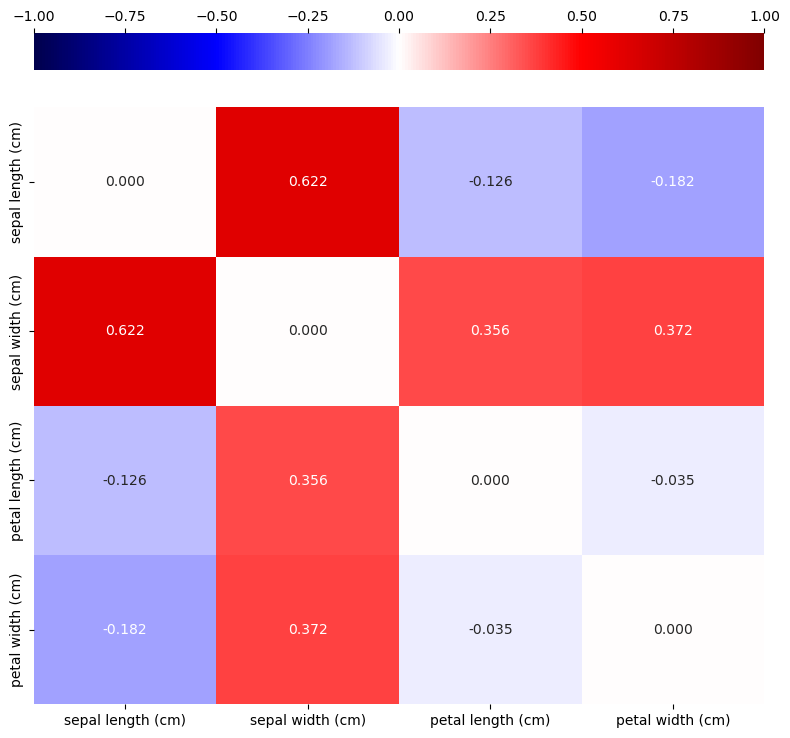

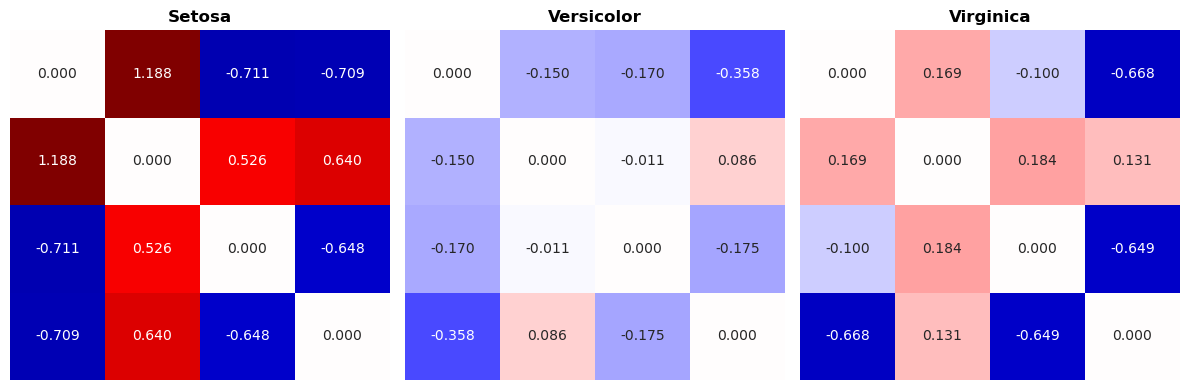

In [19]:
utils.plot_data(real_iris, 'target', vae_df)

Let's train the Conditional GAN.

In [20]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [21]:
for epoch in tqdm(range(501), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], 4)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 10 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/50 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/50 | DLoss: 0.6870 | GLoss 0.7114
MEAN: [ 0.154  0.075 -0.174 -0.075]
STD:  [0.939 0.946 0.944 0.956]
MIN:  [-1.538 -2.124 -1.611 -1.39 ]
MAX:  [2.466 3.056 1.479 1.542]
SKEW: [ 0.274  1.552 -0.251  0.281]
KURT: [-0.421 -2.119 -0.713 -0.772]

Epoch 10/50 | DLoss: 0.6132 | GLoss 0.7598
MEAN: [ 0.052  0.904  0.343 -0.234]
STD:  [0.855 0.653 0.756 0.911]
MIN:  [-1.476 -0.329 -0.364 -1.486]
MAX:  [2.098 3.369 1.762 1.152]
SKEW: [-0.215  0.807  0.673 -0.401]
KURT: [-0.908  0.272 -1.994 -1.513]

Epoch 20/50 | DLoss: 0.4022 | GLoss 1.2756
MEAN: [1.843 2.165 2.711 1.253]
STD:  [ 0.294  0.047 -0.225  0.362]
MIN:  [1.998 2.902 4.817 1.867]
MAX:  [3.023 3.61  2.347 1.936]
SKEW: [0.594 0.882 0.2   0.462]
KURT: [-0.021  0.333 -1.079 -1.083]

Epoch 30/50 | DLoss: 0.4905 | GLoss 1.1180
MEAN: [ 0.75  -0.895  0.64  -0.471]
STD:  [0.634 0.552 0.57  0.801]
MIN:  [-0.065 -2.589  0.395 -1.576]
MAX:  [2.648 0.635 1.763 0.514]
SKEW: [ 0.825 -0.236  0.352 -0.797]
KURT: [-0.161  0.246 -1.187 -1.667]




Epoch 330/50 | DLoss: 0.6923 | GLoss 0.6992
MEAN: [ 0.352 -0.152 -0.016  0.157]
STD:  [-0.434  0.206 -0.256  0.078]
MIN:  [0.937 0.795 0.248 0.108]
MAX:  [-0.263  0.639 -0.429  0.707]
SKEW: [0.322 1.278 0.093 0.297]
KURT: [ 0.761 -2.074  0.011  0.122]

Epoch 340/50 | DLoss: 0.6986 | GLoss 0.7044
MEAN: [-0.17  -0.257 -0.101 -0.193]
STD:  [-0.235 -0.041  0.076  0.247]
MIN:  [ 0.237  1.264 -0.199 -0.445]
MAX:  [-1.015 -0.462  0.049  0.432]
SKEW: [0.095 0.817 0.018 0.097]
KURT: [ 0.375 -1.205 -0.059  0.039]

Epoch 350/50 | DLoss: 0.7085 | GLoss 0.7063
MEAN: [-0.225  0.057  0.126 -0.051]
STD:  [-0.275 -0.277  0.039 -0.089]
MIN:  [0.221 2.401 0.028 0.104]
MAX:  [-1.389 -0.401  0.587  0.189]
SKEW: [0.003 0.781 0.138 0.162]
KURT: [ 0.192 -0.712  0.055  0.15 ]

Epoch 360/50 | DLoss: 0.6892 | GLoss 0.7350
MEAN: [-0.256  0.146  0.203  0.158]
STD:  [-0.112 -0.334  0.095 -0.088]
MIN:  [-0.031  2.209 -0.004  0.322]
MAX:  [-0.729 -0.259  0.824  0.381]
SKEW: [0.244 0.438 0.148 0.155]
KURT: [0.224 0.0

In [22]:
gan_df = pd.DataFrame(std_scl.inverse_transform(gen_z.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

In [23]:
utils.describe_data(real_iris, 'target', gan_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.930      6.102   
     sepal width (cm)   3.428      2.770     2.974     3.754      2.839   
     petal length (cm)  1.462      4.260     5.552     2.658      4.310   
     petal width (cm)   0.246      1.326     2.026     0.127      1.173   
STD  sepal length (cm)  0.352      0.516     0.636     0.399      0.201   
     sepal width (cm)   0.379      0.314     0.322     0.284      0.336   
     petal length (cm)  0.174      0.470     0.552     0.313      0.275   
     petal width (cm)   0.105      0.198     0.275     0.070      0.075   
MIN  sepal length (cm)  4.300      4.900     4.900     5.131      5.874   
     sepal width (cm)   2.300      2.000     2.200     3.159      1.593   
     petal length (cm)  1.000      3.000     4.500     2.078      3.915   
     petal width (cm)   0.100      1.000     1.400    -0.143      0.897   
MAX  sepal length (cm)  5.800      7.000     7.900     7.171      6.740   
     sepal width (cm)   4.400      3.400     3.800     4.672      3.439   
     petal length (cm)  1.900      5.100     6.900     3.679      5.092   
     petal width (cm)   0.600      1.800     2.500     0.221      1.255   
SKEW sepal length (cm)  0.116      0.102     0.114     0.505      0.851   
     sepal width (cm)   0.040     -0.352     0.355     0.718     -1.412   
     petal length (cm)  0.103     -0.588     0.533     0.485      0.615   
     petal width (cm)   1.216     -0.030    -0.126    -1.678     -1.657   
KURT sepal length (cm) -0.346     -0.599    -0.088     0.553      0.286   
     sepal width (cm)   0.744     -0.448     0.520     0.998      3.156   
     petal length (cm)  0.805     -0.074    -0.256     0.821     -0.361   
     petal width (cm)   1.434     -0.488    -0.661     3.164      3.175   
IQR  sepal length (cm)  0.400      0.700     0.675     0.503      0.350   
     sepal width (cm)   0.475      0.475     0.375     0.336      0.431   
     petal length (cm)  0.175      0.600     0.775     0.370      0.474   
     petal width (cm)   0.100      0.300     0.500     0.071      0.087   

                                  
                       virginica  
MEAN sepal length (cm)     6.662  
     sepal width (cm)      3.081  
     petal length (cm)     5.389  
     petal width (cm)      1.690  
STD  sepal length (cm)     0.323  
     sepal width (cm)      0.285  
     petal length (cm)     0.473  
     petal width (cm)      0.096  
MIN  sepal length (cm)     5.990  
     sepal width (cm)      2.322  
     petal length (cm)     4.417  
     petal width (cm)      1.397  
MAX  sepal length (cm)     7.483  
     sepal width (cm)      3.668  
     petal length (cm)     6.336  
     petal width (cm)      1.807  
SKEW sepal length (cm)    -0.229  
     sepal width (cm)     -0.759  
     petal length (cm)    -0.445  
     petal width (cm)     -1.541  
KURT sepal length (cm)    -0.136  
     sepal width (cm)      0.249  
     petal length (cm)    -0.558  
     petal width (cm)      1.512  
IQR  sepal length (cm)     0.389  
     sepal width (cm)      0.292  
     petal length (cm)     0.641  
     petal width (cm)      0.062

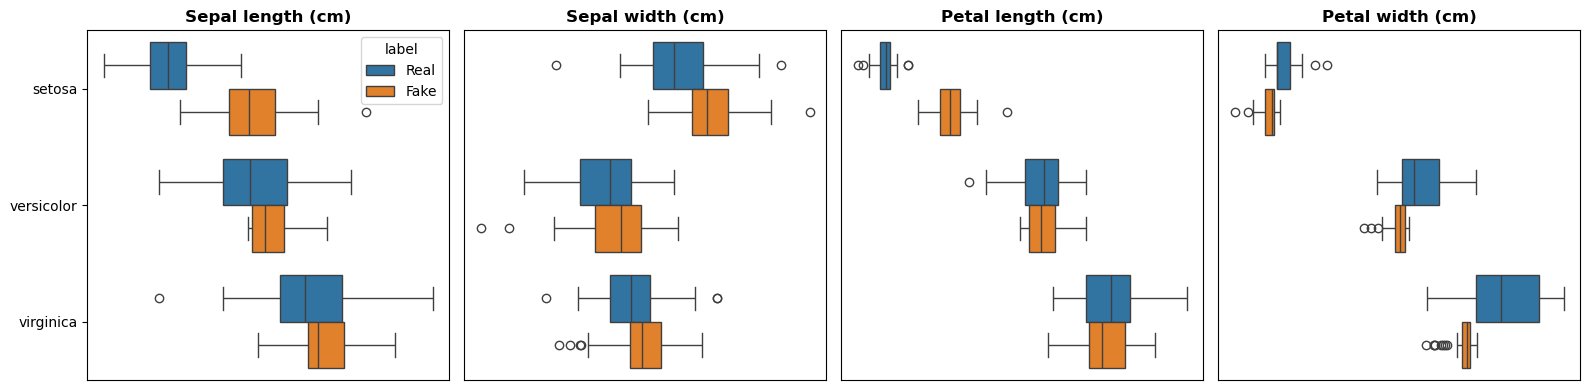

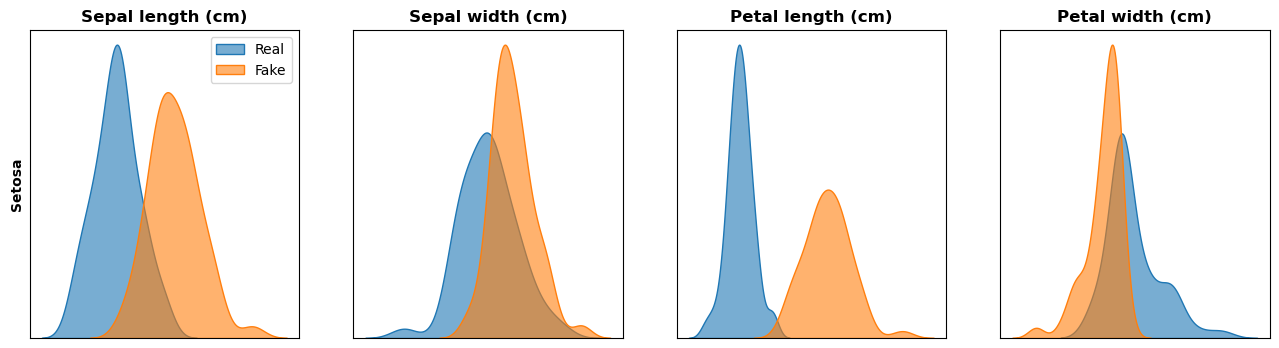

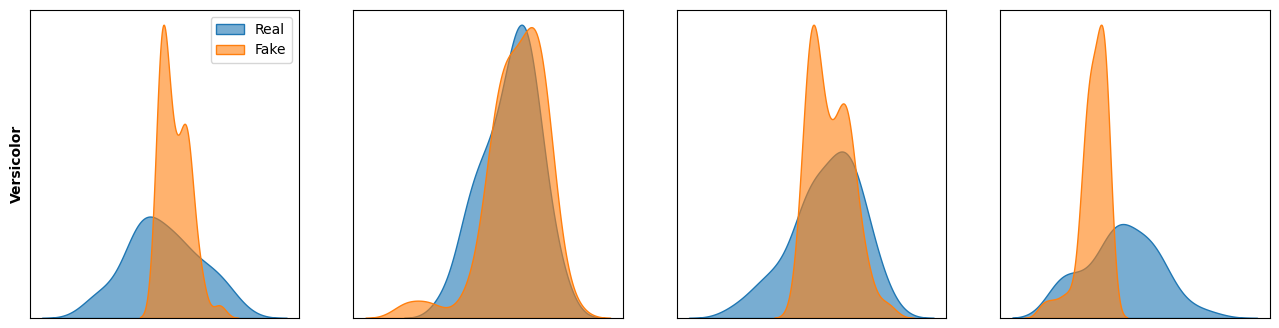

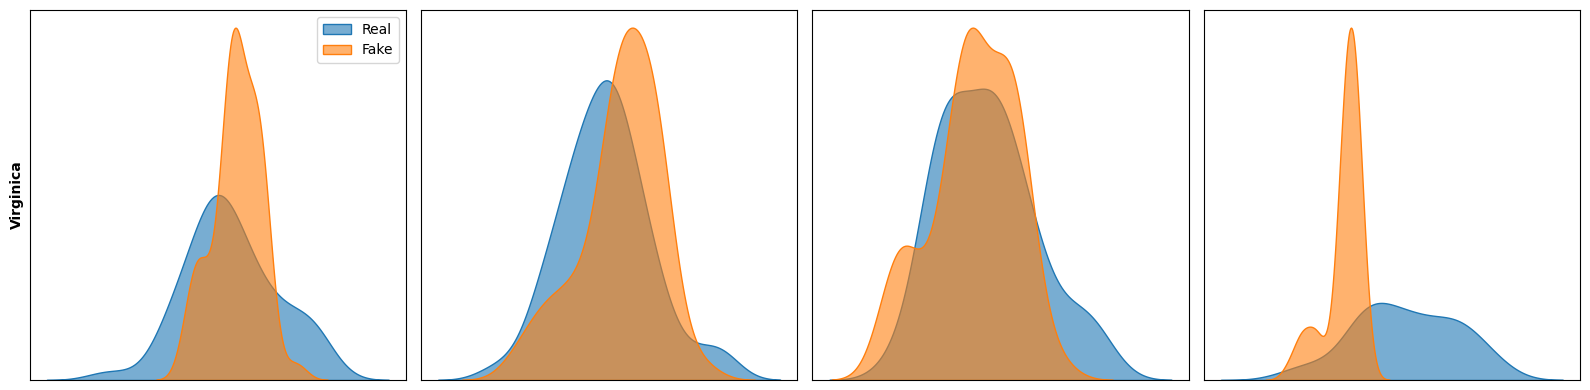

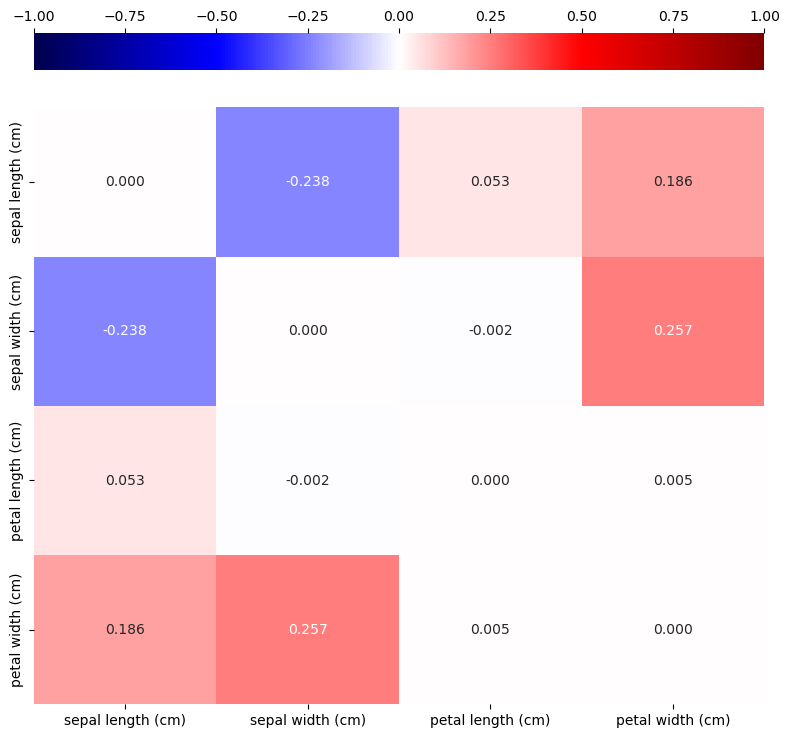

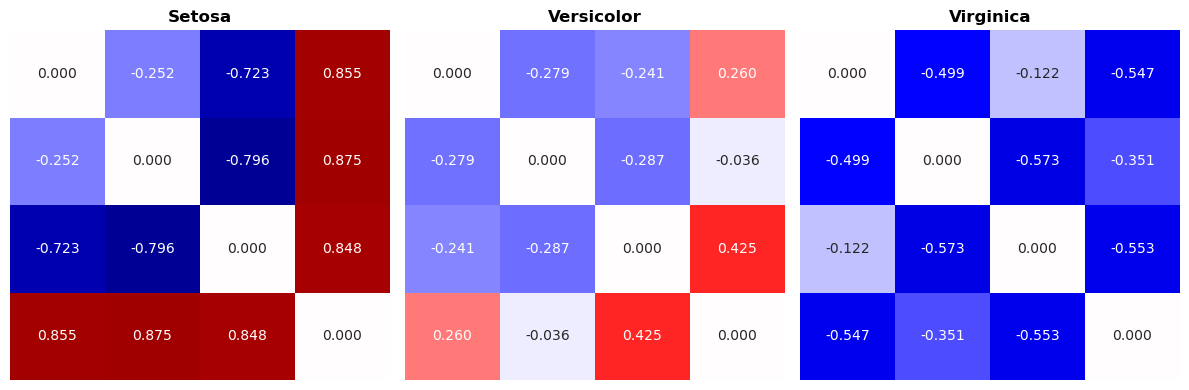

In [24]:
utils.plot_data(real_iris, 'target', gan_df)

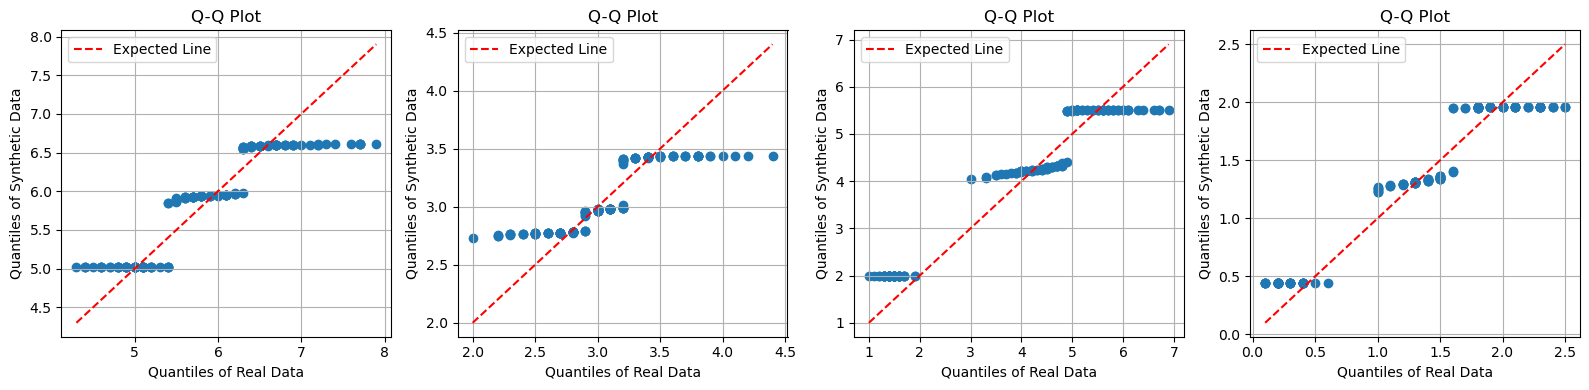

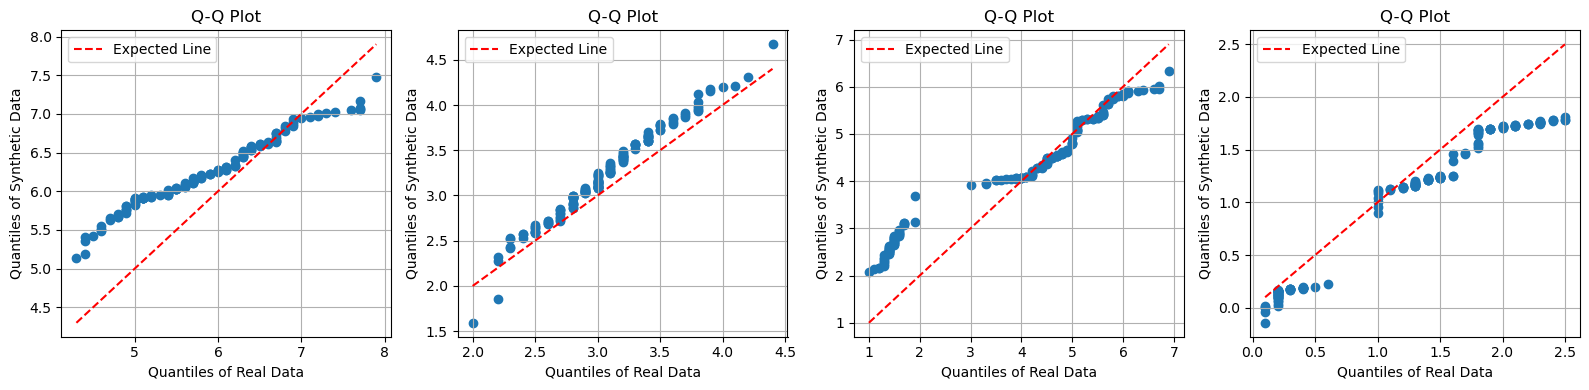

In [25]:
utils.plot_quantiles(real_iris, vae_df)
utils.plot_quantiles(real_iris, gan_df)

The performance of the models is clear: using Q-Q plots we see that the data generated with the simpler GAN show better overlap with the actual data. We will follow this path.